<a href="https://colab.research.google.com/github/ddekun/Data_analysis_algorithms/blob/lesson4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Алгоритмы анализа данных

## Урок 4. Алгоритм построения дерева решений

### Домашнее задание

**1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева (функция print_tree).**

In [3]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [57]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 4, n_informative = 4, 
                                        n_classes = 2, n_redundant=0, n_clusters_per_class=1, random_state=23)

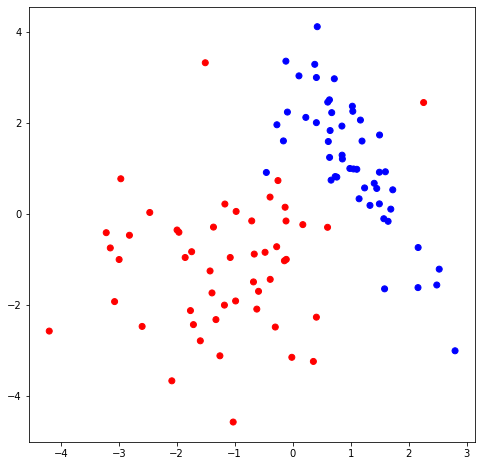

In [58]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [59]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [60]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [61]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [62]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [63]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

**Добавим критерии останова: количество используемых признаков (n_features ) и количество листьев (min_leaf)**

In [64]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, n_features, min_leaf):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:  # Не больше имеющихся в наборе данных
        n_features = data.shape[1]  # столбцов-признаков
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [65]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, n_features, min_leaf):
    quality, t, index = find_best_split(data, labels, n_features, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (quality == 0):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch  = build_tree(true_data, true_labels, n_features, min_leaf)
    false_branch = build_tree(false_data, false_labels, n_features, min_leaf)
 
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [66]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [67]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [68]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                    classification_labels, test_size = 0.3, random_state = 1)

In [69]:
# Построим дерево по обучающей выборке и зададим кол-во признаков = 3 и кол-во листьев 4
my_tree = build_tree(train_data, train_labels, n_features=3, min_leaf=4)

In [70]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог',  str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.3011223579111354
--> True:
  Прогноз: 0
--> False:
  Индекс 1
  Порог -0.2391707287713687
  --> True:
    Индекс 0
    Порог 0.3556916119374769
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог 1.4939053991962525
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [71]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[0:20]

[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]

In [72]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
answers[:20]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

In [73]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [74]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [75]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

83.33333333333334

Text(0.5, 1.0, 'Test accuracy=83.33')

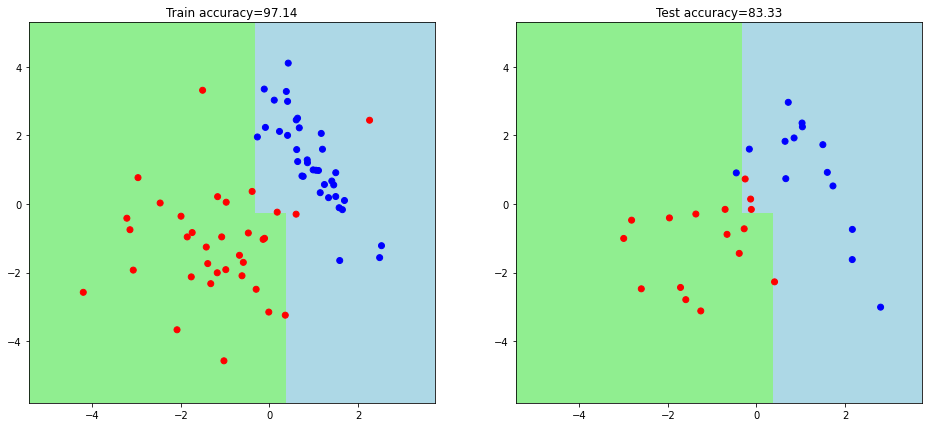

In [76]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
light_colors = ListedColormap(['lightgreen', 'lightblue'])
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [105]:
# Построим дерево по обучающей выборке и зададим кол-во признаков = 4 и кол-во листьев 3
my_tree = build_tree(train_data, train_labels, n_features=4, min_leaf=3)

In [106]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

In [107]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [108]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

86.66666666666667

**При повышении кол-ва признаков до 4-ч и уменьшения листьев до 3-х, точность прогноза повысилась**

Text(0.5, 1.0, 'Test accuracy=86.67')

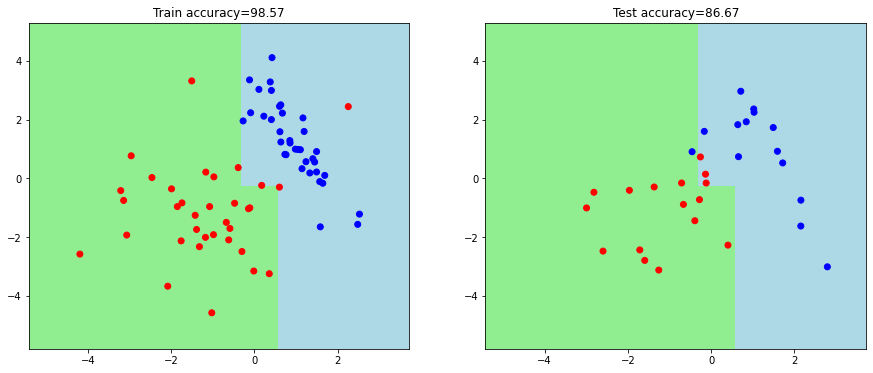

In [109]:
plt.figure(figsize = (15, 6))
# график обучающей выборки
light_colors = ListedColormap(['lightgreen', 'lightblue'])
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')